In [1]:
import os
import sys
from flaml import AutoML
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

sys.path.append('../')

### Load training data

In [2]:
from src.classifiers.dataset import get_X_y

train_val_test_dir = os.path.abspath("../data/affinity_data/example/")

train = pd.read_csv(os.path.join(train_val_test_dir, "train.csv"))
val = pd.read_csv(os.path.join(train_val_test_dir, "val.csv"))
test = pd.read_csv(os.path.join(train_val_test_dir, "test.csv"))

# this takes ~1 min to load large (500k seqs) datasets
X_train, y_train = get_X_y(train, one_dim=True)
X_val,   y_val   = get_X_y(val, one_dim=True)

train.head()

,seq,class,label,edit_distance
0,YTTSASYDYT,low,0,9
1,WANTLSVHIR,high,1,9
2,YALDRMYAFD,high,1,6
3,FDLVGFYANG,mid,0,6
4,YTAPSSYSLI,high,1,9


### Train

In [3]:
# note, FLAML is minimal code so no additional code is required in src/classifiers
seed = 0
max_seconds_to_train = 20

automl = AutoML()
automl.fit(X_train=X_train,
           y_train=y_train,
           task="classification",
           X_val=X_val,
           y_val=y_val,
           seed=seed,
           early_stop=True,
           verbose=2,
           time_budget=max_seconds_to_train)

# show best model settings
automl.model.model

XGBClassifier(base_score=None, booster=None, callbacks=[],
              colsample_bylevel=1.0, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy='lossguide',
              importance_type=None, interaction_constraints=None,
              learning_rate=0.6111567578893214, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=0, max_leaves=9,
              min_child_weight=0.0672775807171708, missing=nan,
              monotone_constraints=None, n_estimators=8, n_jobs=-1,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

### Evaluate

In [4]:
from src.classifiers.evaluate import (
    get_metrics,
    plot_predictions_histogram,
    plot_PR_AUC,
    plot_PR_AUC_by_edit_distance,
    plot_predictions_histogram_stack_editdist
)
from src.plotting import buzz_colours

# trim for speed of testing when test set is large
df_evaluate = test[:10000]
X_evaluate,  y_evaluate  = get_X_y(df_evaluate, one_dim=True)

predictions_pos_neg_probs = automl.predict_proba(X_evaluate)
predictions = np.array(predictions_pos_neg_probs[:,1])

df_evaluate["predictions"] = predictions
get_metrics(y_evaluate, predictions)

,PR AUC,F-score,MCC,ROC AUC,Balanced Accuracy,Youden cutoff
0,0.772,0.695,0.536,0.859,0.783,0.34


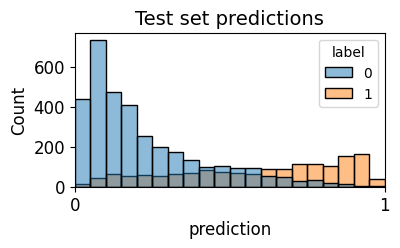

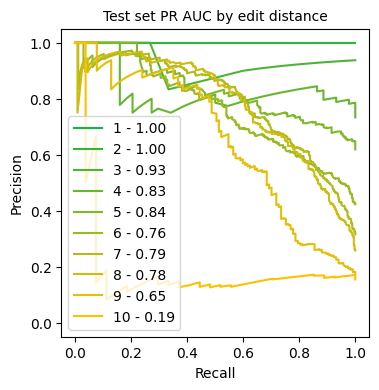

In [5]:
buzz_cols = buzz_colours()
c1 = buzz_cols["dark_green"]
c2 = buzz_cols["yellowy_gold"]
colour_start_end = (c1,c2)

plot_predictions_histogram(y_evaluate, predictions, title="Test set predictions")
plot_PR_AUC_by_edit_distance(y_evaluate, predictions, df_evaluate, colour_start_end=colour_start_end, title="Test set PR AUC by edit distance")